<center>

<h1 style="font-size: 24px; font-weight: bold;">Praca domowa 4</h1>

</center>


<h1 style="font-size: 18px; font-weight: bold;">Wizualizacja źródłowa</h1>

Zdecydowałem się dokonać analizy i poprawy kartogramu znajdującego się w dashboardzie dostępnym pod poniższym linkiem:

https://public.tableau.com/app/profile/venkatesh.chandra7408/viz/CanadaCOVID-19Monitor/Situation.


Tak oto wygląda wykres, który będzie przeze mnie poprawiany:


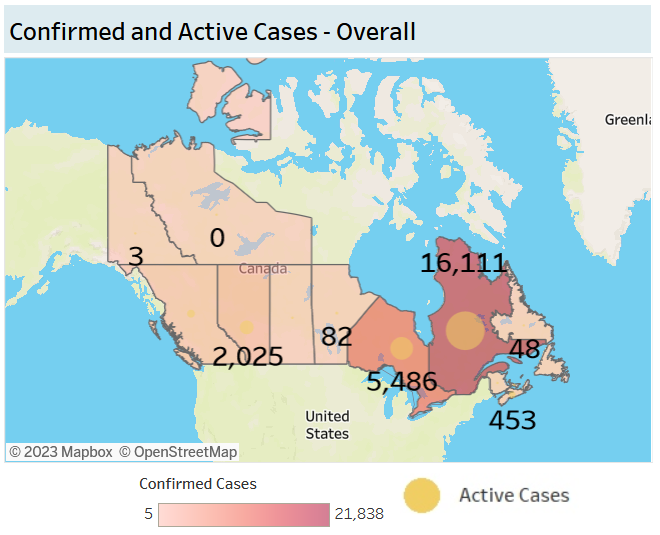


W oryginale jest on również interaktywny, o czym można się przekonać, klikając w pierwszy link. Po najechaniu kursorem myszki na dany region, wyświetla się informacja o nazwie prowincji, liczbie potwierdzonych przypadków i przypadków aktywnych.


<h1 style="font-size: 18px; font-weight: bold;">Co należy poprawić?</h1>

Zauważam liczne błędy w wykonaniu tego wykresu:

- Na pierwszy rzut oka rażą mnie umieszczone w zupełnie losowych miejscach na wykresie liczby. Nie wiadomo ani jaką zmienną one przedstawiają, ani, do którego regionu się odnoszą. W niektórych przypadkach bowiem jedna liczba jest zapisana na granicy trzech regionów.
- Skala jest ciągła, co raczej nie jest dobrym wyborem dla tego typu wykresu, gdyż ludzkie oko ma problem z oceną subtelnych różnic między odcieniami kolorów.
- Wybrane odwzorowanie (Merkatora) nie jest dobrym wyborem dla Kanady - kraju o dużej rozciągłości równoleżnikowej położonego stosunkowo blisko bieguna północnego.
- Oznaczona przez żółte koło zmienna 'Active Cases' zlewa się w niektórych przypadkach z kolorem tła. W dodatku nigdzie na wykresie nie ma zdefiniowanej dla niej skali.
- Biorąc pod uwagę również inne wykresy na tym dashboardzie, trudno tak naprawdę określić, który dokładnie dzień został przedstawiony na kartogramie.
- Na tego typu wykresach nie jest rekomendowane stosowanie danych bezwzględnych, lepiej przedstawić dane względne, uwzględniające populację poszczególnych regionów.



<h1 style="font-size: 18px; font-weight: bold;">Kod niezbędny do wygenerowania poprawnej wizualizacji</h1>

Poprawy wykresu zdecydowałem się dokonać na podstawie oficjalnych danych kanadyjskiego rządu:
https://health-infobase.canada.ca/covid-19/#a4
    
Przydatny do tworzenia map w pakiecie plotly będzie również plik w formacie geojson zawierający informacje o granicach poszczególnych regionów pobrany ze strony:
https://thomson.carto.com/tables/canada_provinces/public/map

Skorzystam również z danych dotyczących populacji poszczególnych regionów Kanady ze strony:
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901&cubeTimeFrame.startMonth=01&cubeTimeFrame.startYear=2020&cubeTimeFrame.endMonth=04&cubeTimeFrame.endYear=2020&referencePeriods=20200101%2C20200401


Przejdźmy więc do kodu:

In [ ]:
import pandas as pd
import plotly_express as px
import json

In [ ]:
df_covid_first_version = pd.read_csv("ca_pr_day_n.csv")
df_covid_second_version = pd.read_csv("covid19.csv")

In [ ]:
df_covid_second_version = df_covid_second_version.rename(columns = {"prname" : "province"})
df_covid_second_version['date'] = pd.to_datetime(df_covid_second_version['date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d').astype(str)

In [ ]:
df_merged = pd.merge(df_covid_first_version, df_covid_second_version, how = "inner", on = ["province", "date"])

In [ ]:
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Ustalanie kwartału na podstawie miesiąca
df_merged['quarter'] = df_merged['date'].dt.quarter

In [ ]:
population = pd.read_csv("canada_population.csv")

In [ ]:
population = population.iloc[:,[0,1,9]]

# Dodanie dnia do daty w formie "yyyy-mm" (przyjmujemy dzień 01)
population['REF_DATE'] = pd.to_datetime(population['REF_DATE'] + '-01')

# Ustalenie kwartału na podstawie daty
population['quarter'] = population['REF_DATE'].dt.quarter
population = population.rename(columns = {"GEO" : "province"})
population = population.iloc[:,[1,2,3]]

In [ ]:
df_absolute_data = pd.merge(df_merged, population, how = "left", on = ["province", "quarter"])

In [ ]:
df_absolute_data = df_absolute_data.iloc[:,[0,2,3,12,13,15,16,29]]

In [ ]:
df_relative_data = df_absolute_data.assign(
    TotalCasesPerPopulation=(df_absolute_data['totalcases'] * 100000) / df_absolute_data['VALUE'],
    CasesInLast7DaysPerPopulation=(df_absolute_data['numtotal_last7'] * 100000) / df_absolute_data['VALUE'],
    TotalDeathsPerPopulation=(df_absolute_data['numdeaths'] * 100000) / df_absolute_data['VALUE'],
    DeathsInLast7DaysPerPopulation=(df_absolute_data['numdeaths_last7'] * 100000) / df_absolute_data['VALUE']
)

df_relative_data = df_relative_data.round({'TotalCasesPerPopulation': 2,
                                           'CasesInLast7DaysPerPopulation': 2,
                                           'TotalDeathsPerPopulation': 2,
                                           'DeathsInLast7DaysPerPopulation': 2})

In [ ]:
df_relative_data['date'] = pd.to_datetime(df_relative_data['date'])

df_relative_data['date'] = df_relative_data['date'].dt.date


In [ ]:
df = df_relative_data
df['category'] = ''
df['date'] = df['date'].apply(lambda x: str(x))

In [ ]:
#categorizing the number of cases and assign each category to each row
def set_cat(row):
    if row['TotalCasesPerPopulation'] == 0:
        return '0'
    if row['TotalCasesPerPopulation'] > 0 and row['TotalCasesPerPopulation'] < 101:
        return '1 - 100'
    if row['TotalCasesPerPopulation'] > 101 and row['TotalCasesPerPopulation'] < 201:
        return '101 - 200'
    if row['TotalCasesPerPopulation'] > 201 and row['TotalCasesPerPopulation'] < 301:
        return '201 - 300'
    if row['TotalCasesPerPopulation'] > 301 and row['TotalCasesPerPopulation'] < 401:
        return '301 - 400'
    if row['TotalCasesPerPopulation'] > 401 and row['TotalCasesPerPopulation'] < 501:
        return '401 - 500'
    if row['TotalCasesPerPopulation'] > 501:
        return '501 and higher'

In [ ]:
df = df.assign(category=df.apply(set_cat, axis=1))

In [ ]:
# Adds all available categories to each time frame
catg = df['category'].unique()
dts = df['date'].unique()

for tf in dts:
    for i in catg:
        new_row = pd.DataFrame({
            'date': [tf],
            'TotalCasesPerPopulation': ['N'],
            'cartodb_id': ['0'],
            'category': [i]
        })

        df = pd.concat([df, new_row], ignore_index=True)

In [ ]:
# assign mp to the geojson data
with open("canada_provinces.geojson", "r") as geo:
    mp = json.load(geo)

In [ ]:
# Create choropleth map
fig = px.choropleth(df,
                    locations="cartodb_id",
                    geojson=mp,
                    featureidkey="properties.cartodb_id",
                    color="category",
                    color_discrete_map={
                        '0': '#d4d9db',
                        '1 - 100' : '#fff323',
                        '101 - 200' : '#ffc107',
                        '201 - 300' : '#ff9109',
                        '301 - 400' : '#e64008',
                        '401 - 500' : '#921b07',
                        '501 and higher' : '#450b0c'},
                    category_orders={
                      'category' : [
                          '0',
                          '1 - 100',
                          '101 - 200',
                          '201 - 300',
                          '301 - 400',
                          '401 - 500',
                          '501 and higher'
                      ]
                    },
                    animation_frame="date",
                    scope='north america',
                    title='<b>COVID-19 cases in Canadian provinces</b>',
                    labels={'totalcases' : 'Total number of cases',
                            'TotalCasesPerPopulation' : 'Total number of cases per 100,000 inhabitants',
                           'numtotal_last7' : 'New cases in last 7 days', 
                            'numdeaths' : 'Total number of deaths related to COVID-19',
                           'TotalDeathsPerPopulation' : 'Total number of deaths related to COVID-19 per 100,000 inhabitants',
                           'numdeaths_last7' : 'New deaths in last 7 days'},
                    hover_name='province',
                    hover_data={ 
                        'totalcases' : True,
                        'TotalCasesPerPopulation' : True,
                        'numtotal_last7' : True,
                        'numdeaths' : True,
                        'TotalDeathsPerPopulation' : True,
                        'numdeaths_last7' : True,
                        'cartodb_id' : False,
                        'category' : False,
                        'date' : False
                    },
                    # height=900,
                    locationmode='geojson-id',
                    )

In [ ]:
# Adjust map layout stylings
fig.update_layout(
    showlegend=True,
    legend_title_text='<b>Total number of cases per 100,000 inhabitants by province/territory</b>',
    font={"size": 16, "color": "#808080", "family" : "calibri"},
    margin={"r":60,"t":100,"l":40,"b":40},
    legend=dict(orientation='v'),
    geo=dict(bgcolor='rgba(0,0,0,0)', lakecolor='#e0fffe'),
    title_x=0.5
)

# Adjust map geo options
fig.update_geos(showcountries=False, showcoastlines=False,
                showland=False, fitbounds="locations",
                subunitcolor='white')

In [ ]:
fig.write_html("PoprawionyWykres.html")

Poniżej wygląd poprawionego wykresu. Wersja interaktywna dostępna w pliku HTML.

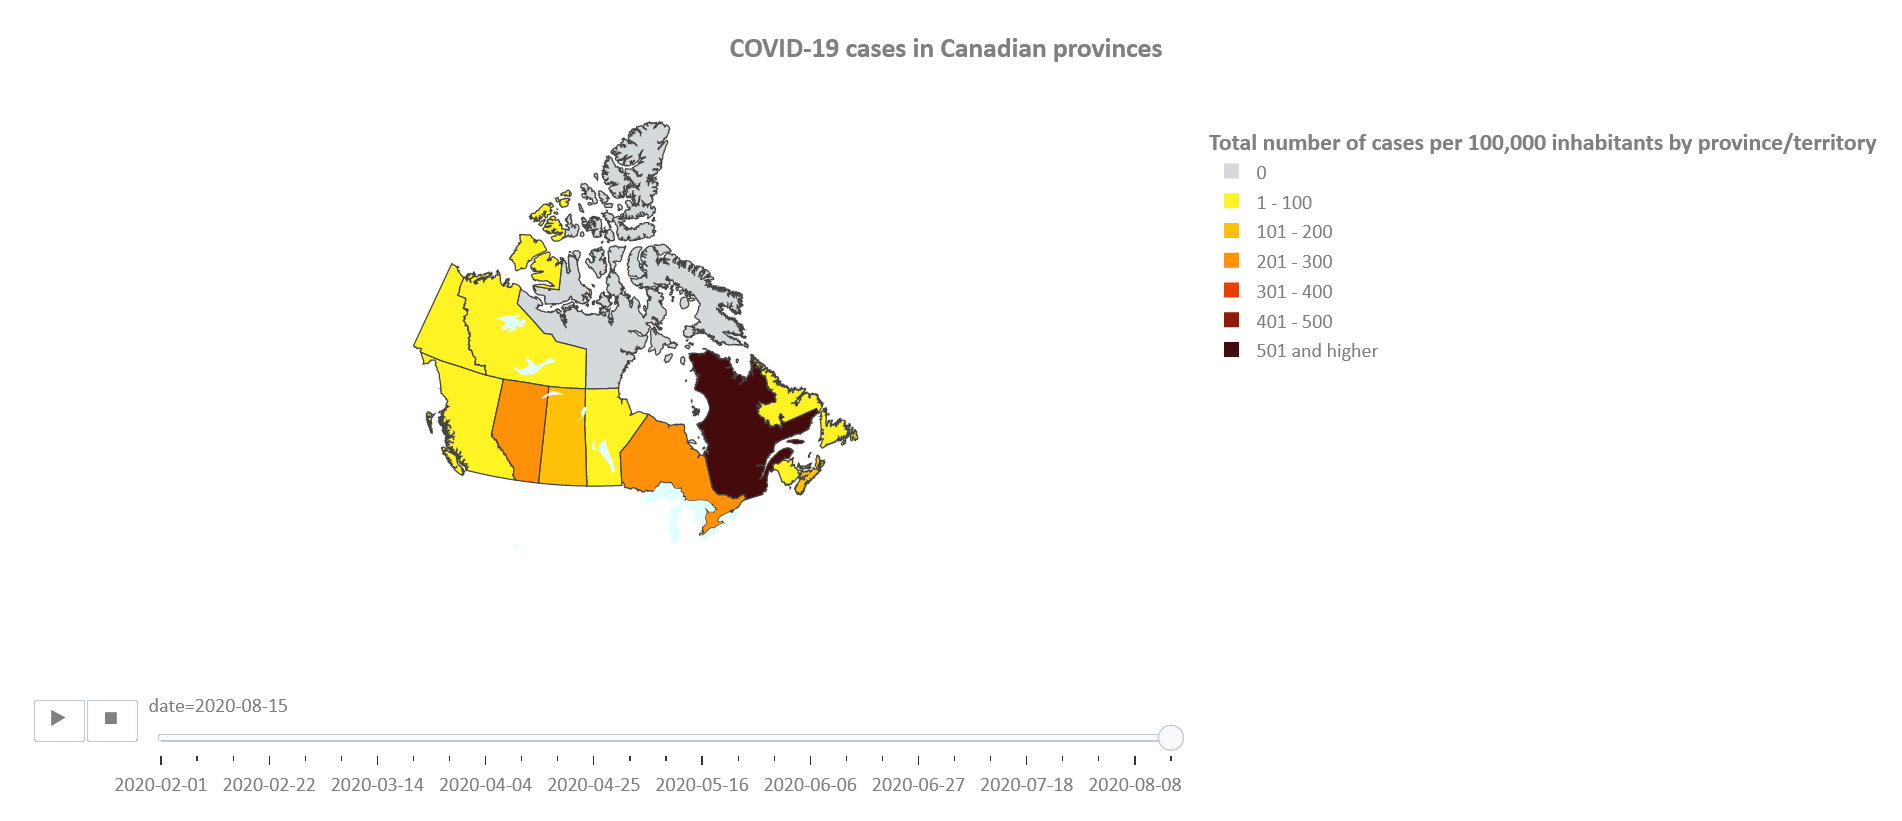

<h1 style="font-size: 18px; font-weight: bold;">Co się zmieniło?</h1>

1. Podjąłem decyzję o pozbyciu się zbędnych liczb z kartogramu. Główny przekaz dotyczący liczby zachorowań na sto tysięcy mieszkańców jest przekazany przez kolory, nie ma sensu dublować tej informacji.
2. Podzieliłem ciągłą zmienną w dyskretne przedziały, dzięki temu czytelnik powinien łatwiej zauważyć różnice.
3. Zamiast danych bezwzględnych, wyliczyłem względny wskaźnik zależny od liczby mieszkańców danego regionu, dzięki czemu ten wykres przedstawia nam realną sytuację w poszczególnych regionach.
4. Zamiast odwzorowania Merkatora, zdecydowałem się wybrać odwzorowanie stożkowe - oficjalne odwzorowanie Kanady.
5. Po najechaniu kursorem myszy na wykres użytkownik otrzyma pełen zestaw informacji, zawierający dane względne i bezwzględne dotyczące łącznej liczby przypadków, ale także tych najnowszych z perspektywy danej daty.
6. Wykres jest animowany, po naciśnięciu przycisku "play" zaczyna poruszać nam się oś czasowa i wykres jest odpowiednio modyfikowany.